/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_15292/28695476.py:58: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=data.reset_index(), x='stimulus', y='strength', hue='rf', palette=['k'], alpha=0.5, legend=False)


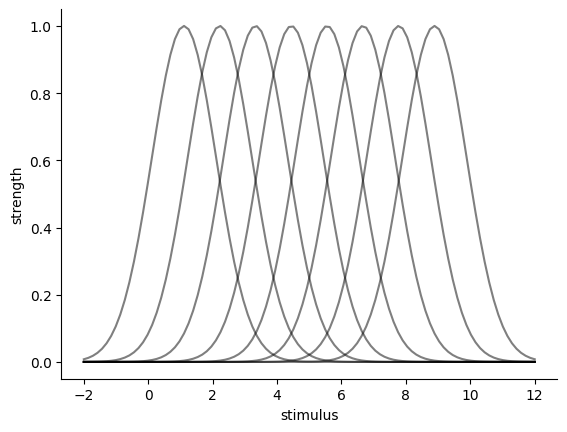

In [43]:
"""
Fisher information to estimate precision of encoding parameters across stimulus space
=====================================================================================

Fisher information is defined as the expected value of the square of the derivative of the log-likelihood
with respect to some parameter.


.. math::
    I(\\theta) = E[ (\\frac{\\partial}{\\partial \\theta} \\log f(X; \\theta) )^2 ]

In our case, the parameter $\theta$ might be the stimulus (dimension) we are interested in. What the Fisher information
now gives us, _given a fitted encoding *and* noise model_, is the expected precision of the estimated
parameter across the stimulus space.

In other words, using the Fisher information, we can already estimate how well we can estimate the stimulus
at different locations in stimulus space without actually doing any decoding.

Notably, Fisher information also plays a crucial role in efficient coding theory. In general, the expected
squared error of a likelihood function, given a limited 'information budget',
 can be minimized by using a likelihood function where the Fisher information is proportional
to the derivative of the cummulative prior distribution (:cit:`wei2015bayesian`).

"""

# Import necessary libraries
from braincoder.models import GaussianPRF
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns


# %%
# Set up generating model
# -------------------------------------
# Let's set up a Gaussian PRF on the line that generates some data. 
# We put the centers of the PRFs equally across the line, using a
# the quantiles of a *uniform prior distribution*
# (i.e. the quantiles of a uniform distribution are equally spaced).
# %

# 8 points on the uniform distribution between 0 and 10
mus = ss.uniform(0, 10.).ppf(np.linspace(0.0, 1.0, 10)[1:-1])
parameters = pd.DataFrame({'mu':mus, 'sd':1., 'baseline':0.0, 'amplitude':1.0})[['mu', 'sd', 'amplitude', 'baseline']]

# Let's go over the entire line from 0 to 10
paradigm = pd.Series(np.linspace(-2, 12, 100, dtype=np.float32))

# For now let's assume the noise is spherical
omega = np.identity(len(parameters)).astype(np.float32)

model = GaussianPRF(parameters=parameters, paradigm=paradigm)
data = model.predict(paradigm=paradigm).set_index(pd.Index(paradigm, name='stimulus'))
data = data.stack().to_frame('strength')
data.index.set_names('rf', level=1, inplace=True)

sns.lineplot(data=data.reset_index(), x='stimulus', y='strength', hue='rf', palette=['k'], alpha=0.5, legend=False)
sns.despine()

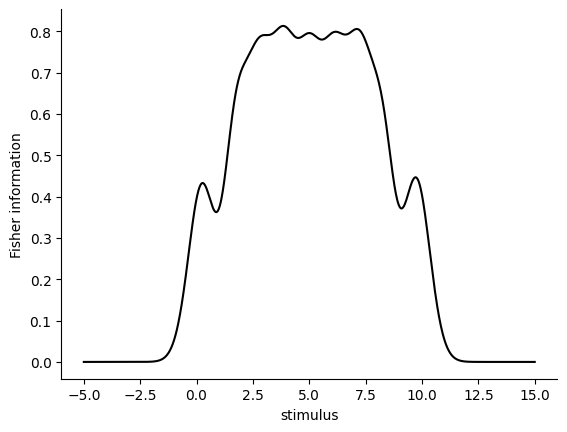

In [44]:
# %%
# Calculate Fisher Information
# ------------------------------
# Now that we have the generating model, we can calculate the Fisher information
# for each stimulus point. We can do this by taking the expectation of the
# second derivative of the log-likelihood with respect to the stimulus.
# the fucntion `Model.get_fisher_information` does this for us by sampling
# from the noise distribution defined by `omega` and calculating the second
# derivative of the log-likelihood with respect to the stimulus using autodiff.
# %

fisher_information = model.get_fisher_information(stimuli=np.linspace(-5, 15, 1000).astype(np.float32), omega=omega, dof=None, n=5000).to_frame()

sns.lineplot(x='stimulus', y='Fisher information', data=fisher_information.reset_index(), color='k')
sns.despine()


# %%
# We can see that the Fisher information is largest at the center of the PRFs and
# decreases towards the edges. This is because the PRFs are more overlapping at the
# center and less overlapping at the edges. This is also reflected in the Fisher
# information, which is a measure of the expected precision of the estimated stimulus
# at each point in stimulus space.
# Outside of the receptive fields, the Fisher information is 0: when stimuli occur
# outside of the receptive fields, the likelihood function is flat and the Fisher
# information is 0.
# %%

In [46]:
omega_correlated

array([[ 1. , -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5,  1. , -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5,  1. , -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5,  1. , -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5,  1. , -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5,  1. , -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5,  1. , -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,  1. ]])

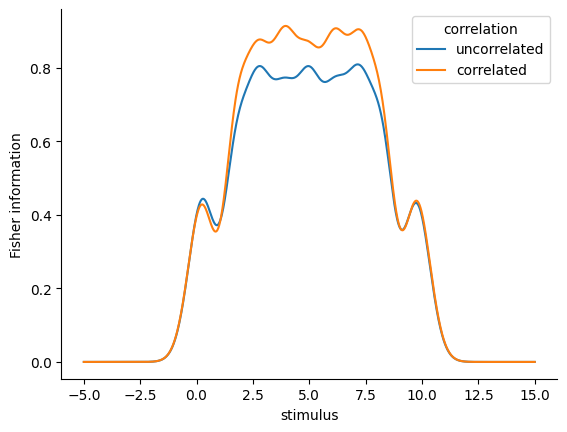

In [53]:
# %%
# Note that if we include some correlation in the errors
# of the receptive fields, under some conditions,
# the Fisher information is higher.
cov = .1
omega_correlated = omega + cov - cov*np.identity(len(parameters))

fisher_information_uncorrelated = model.get_fisher_information(stimuli=np.linspace(-5, 15, 1000).astype(np.float32), omega=omega.astype(np.float32), dof=None, n=5000).to_frame()
fisher_information_correlated = model.get_fisher_information(stimuli=np.linspace(-5, 15, 1000).astype(np.float32), omega=omega_correlated.astype(np.float32), dof=None, n=5000).to_frame()

fisher_information = pd.concat((fisher_information_uncorrelated, fisher_information_correlated), axis=0, keys=['uncorrelated', 'correlated'], names=['correlation'])

sns.lineplot(x='stimulus', y='Fisher information', data=fisher_information.reset_index(), color='k', hue='correlation')
sns.despine()

In [52]:
fisher_information

Fisher information
correlation  stimulus                      
uncorrelated -5.000000         2.257224e-15
             -4.979980         2.862975e-15
             -4.959960         3.628286e-15
             -4.939940         4.594410e-15
             -4.919920         5.812982e-15
...                                     ...
correlated    14.919920        6.207504e-15
              14.939939        4.906256e-15
              14.959960        3.874549e-15
              14.979980        3.057310e-15
              15.000000        2.410439e-15

[2000 rows x 1 columns]

In [31]:
# %%
# We can also validate the Fisher information by decoding and looking 
# at the errors of the decoded stimuli. The Fisher information should
# be inversely proportional to the expected squared error of the decoded
# stimuli.
# %%

import matplotlib.pyplot as plt

paradigm = np.repeat(np.linspace(-2, 12, 50, dtype=np.float32), 100)
simulated_data = model.simulate(paradigm=paradigm, noise=omega)
omega = np.identity(len(parameters)).astype(np.float32)



pdf = model.get_stimulus_pdf(simulated_data, np.linspace(-5, 15, 100), omega=omega)
E = np.trapz(pdf*pdf.columns.values[np.newaxis, :], x=pdf.columns, axis=1)
error = np.sqrt((paradigm - E)**2)
error = pd.Series(error, index=pd.Index(paradigm, name='stimulus')).to_frame('error')
sns.lineplot(x='stimulus', y='error', data=error)
sns.despine()
plt.title('Objective decoding error')



# %%
# same goes for the variance of the decoded posterior
posterior_variance = np.trapz(pdf*(pdf.columns.values[np.newaxis, :] - E[:, np.newaxis])**2, x=pdf.columns, axis=1)

error['posterior sd'] = np.sqrt(posterior_variance)
plt.figure()
sns.lineplot(x='stimulus', y='posterior sd', data=error.reset_index())
sns.despine()
plt.title('Posterior std.')

ValueError: Unable to coerce to Series, length must be 1: given 5000

/Users/gdehol/mambaforge/envs/braincoder/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/envs/braincoder/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/envs/braincoder/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/envs/braincoder/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(*pl

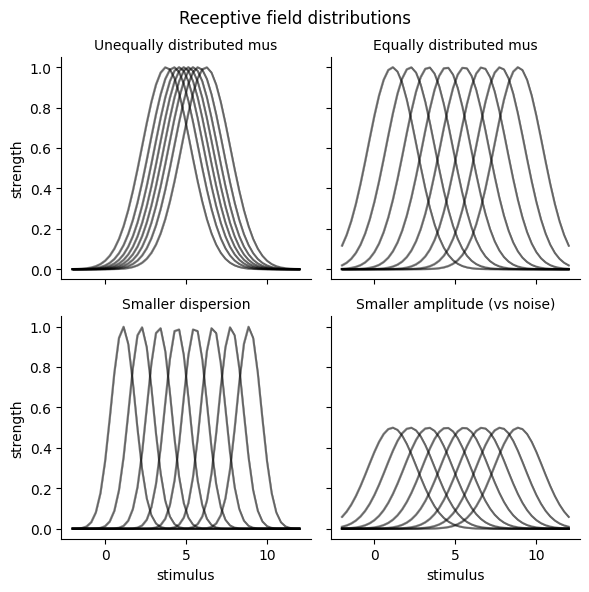

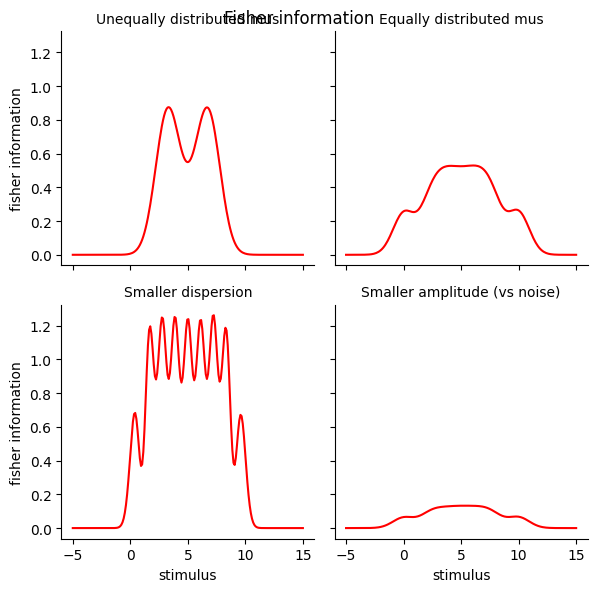

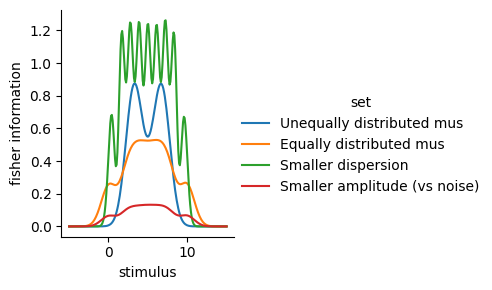

In [32]:
# %%
# Let's calculate the Fisher information for different RF structures

# Set up four different models
mus1 = ss.norm(5, 1.).ppf(np.linspace(1e-4, 1-1e-4, 10)[1:-1])
mus2 = ss.uniform(0, 10).ppf(np.linspace(1e-4, 1-1e-4, 10)[1:-1])
parameters_sets = [{'mu':mus1, 'sd':1.5, 'baseline':0.0, 'amplitude':1.0},
                   {'mu':mus2, 'sd':1.5, 'baseline':0.0, 'amplitude':1.0},
                   {'mu':mus2, 'sd':.75, 'baseline':0.0, 'amplitude':1.0},
                   {'mu':mus2, 'sd':1.5, 'baseline':0.0, 'amplitude':.5}]

parameter_sets = pd.concat([pd.DataFrame(p)[['mu', 'sd', 'amplitude', 'baseline']] for p in parameters_sets], keys=range(4), names=['set', 'parameter'], axis=0)


set_labels = ['Unequally distributed mus', 'Equally distributed mus', 'Smaller dispersion', 'Smaller amplitude (vs noise)' ]


# Make predictions
preds = []
for set, pars in parameter_sets.groupby('set'):
    model = GaussianPRF(parameters=pars.droplevel(0), paradigm=paradigm)
    pred = model.predict(paradigm=paradigm).set_index(pd.Index(paradigm, name='stimulus'))
    preds.append(pred)

preds = pd.concat(preds, keys=set_labels, axis=0, names=['set'])

# Calculate Fisher information
fis = []

stimuli = np.linspace(-5, 15, 200, dtype=np.float32)
for set, pars in parameter_sets.groupby('set'):
    model = GaussianPRF(parameters=pars.droplevel(0), paradigm=paradigm)
    omega = np.identity(len(pars)).astype(np.float32)
    fi = model.get_fisher_information(stimuli=stimuli, omega=omega, n=10000).to_frame("fisher information").set_index(pd.Index(stimuli, name='stimulus'))
    fis.append(fi)

fis = pd.concat(fis, keys=set_labels, axis=0, names=['set'])


# Plot the receptive fields and the Fisher information
tmp = preds.stack().to_frame('strength').join(fis)
g = sns.FacetGrid(col='set', col_wrap=2, data=tmp.reset_index(), sharey=True, col_order=set_labels)
g.map_dataframe(sns.lineplot, 'stimulus', 'strength', hue='parameter', palette=['k'], alpha=0.5)
g.set_titles('{col_name}')
g.figure.suptitle('Receptive field distributions')
g.figure.subplots_adjust(top=.9)


g2 = sns.FacetGrid(col='set', col_wrap=2, data=fis.reset_index(), sharey=True, col_order=set_labels)
g2.map(sns.lineplot, 'stimulus', 'fisher information', color='r')
g2.add_legend()
g2.set_titles('{col_name}')
g2.figure.suptitle('Fisher information')
g.figure.subplots_adjust(top=.9)

g3 = sns.FacetGrid(hue='set', data=fis.reset_index(), sharey=True)
g3.map(sns.lineplot, 'stimulus', 'fisher information')
g3.add_legend()
# g2.fig.suptitle('Fisher information', y=1.05)

In [ ]:
# Write the integral of the fisher information over stimulus space in latex
\int I(x) \, dx


In [42]:

fis.groupby('set').apply(lambda x: np.trapz(x['fisher information'], x=x.index.droplevel(0))).sort_values()

set
Smaller amplitude (vs noise)    1.183404
Equally distributed mus         4.685143
Unequally distributed mus       4.757461
Smaller dispersion              9.459322
dtype: float32

In [ ]:
# %%
# Another intersting phenomenon we can now study is how different
# basis functions/receptive fields modulate the Fisher information.
# For example, it is well-known that numerical receptive fields in
# parietal cortex are shaped as a log-normal distribution. We can
# now study how the Fisher information is modulated by the shape of
# the receptive fields.

<Axes: xlabel='stimulus', ylabel='sqrt(fi)'>

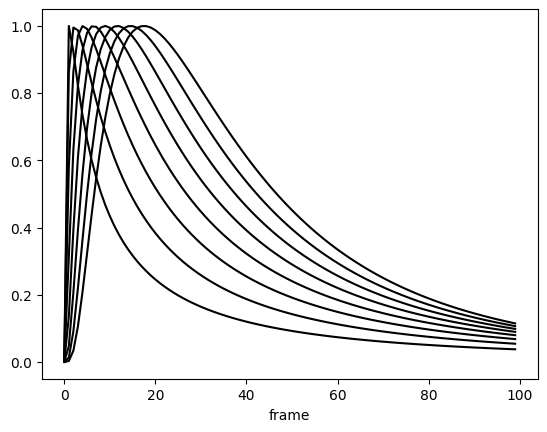

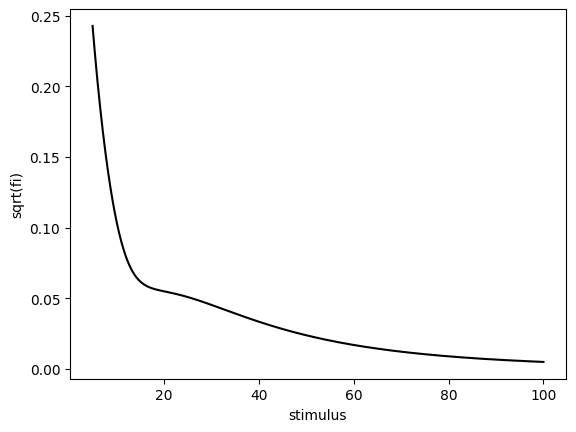

In [23]:
from braincoder.models import LogGaussianPRF
mus = np.linspace(5, 25, 8)

parameters = pd.DataFrame({'mu':mus, 'sd':25., 'baseline':0.0, 'amplitude':1.0})[['mu', 'sd', 'amplitude', 'baseline']]

# Set up model and paradigm and plot the receptive fields
paradigm = np.linspace(0, 100, 100, dtype=np.float32)
model = LogGaussianPRF(parameters=parameters, paradigm=paradigm)
y = model.predict(paradigm=paradigm)

y.plot(c='k', legend=False)

# Calculate Fisher information
omega = np.identity(len(parameters)).astype(np.float32)
fisher_information = model.get_fisher_information(stimuli=np.linspace(5, 100, 1000).astype(np.float32), omega=omega, n=5000).to_frame()

fisher_information['sqrt(fi)'] = np.sqrt(fisher_information['Fisher information'])

plt.figure()
sns.lineplot(x='stimulus', y='sqrt(fi)', data=fisher_information.reset_index(), color='k')

In [18]:
# %%
# Somewhat consistent with the literature, the Fisher information
# behaves roughly like 1/x now, where x is the stimulus. This means that the
# precision of the estimated stimulus decreases with increasing
# stimulus value. 


,Fisher information
stimulus,
0.000000,NaN
0.100100,20.456217
0.200200,9.875210
0.300300,5.865712
0.400400,3.919063
...,...
99.599602,0.000011
99.699699,0.000011
99.799797,0.000011


<Axes: xlabel='stimulus', ylabel='sqrt(fi)'>

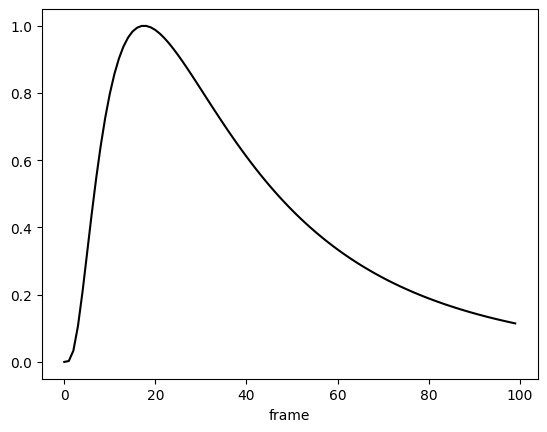

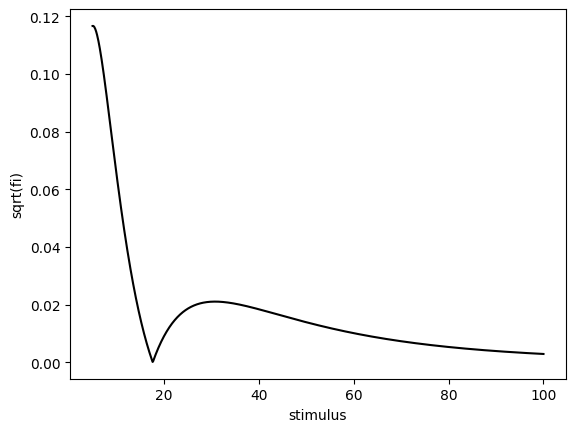

In [29]:
# An interesting corner case is a single receptive field with a log-normal
# kernel.
from braincoder.models import LogGaussianPRF
mus = [25.]

parameters = pd.DataFrame({'mu':mus, 'sd':25., 'baseline':0.0, 'amplitude':1.0})[['mu', 'sd', 'amplitude', 'baseline']]

# Set up model and paradigm and plot the receptive fields
paradigm = np.linspace(0, 100, 100, dtype=np.float32)
model = LogGaussianPRF(parameters=parameters, paradigm=paradigm)
y = model.predict(paradigm=paradigm)

y.plot(c='k', legend=False)

# Calculate Fisher information
omega = np.identity(len(parameters)).astype(np.float32)
fisher_information = model.get_fisher_information(stimuli=np.linspace(5, 100, 1000).astype(np.float32), omega=omega, n=5000).to_frame()

fisher_information['sqrt(fi)'] = np.sqrt(fisher_information['Fisher information'])

plt.figure()
sns.lineplot(x='stimulus', y='sqrt(fi)', data=fisher_information.reset_index(), color='k')

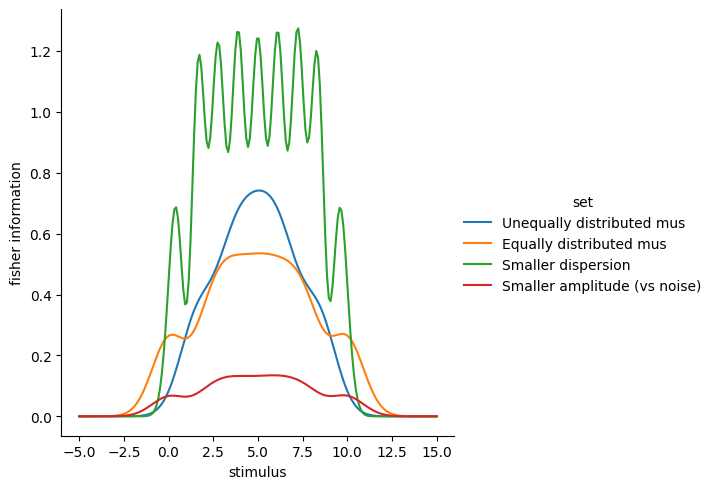

In [ ]:
g3 = sns.FacetGrid(hue='set', data=fis.reset_index(), sharey=True, height=5.)
g3.map(sns.lineplot, 'stimulus', 'fisher information')
g3.add_legend()
# g2.fig.suptitle('Fisher information', y=1.05)

In [ ]:
weights = np.identity(8)

In [ ]:
import tensorflow as tf
def get_fisher_information(self, stimuli, omega=None, dof=None, weights=None, parameters=None, n=1000):

    if omega is None:
        omega = self.omega

    if omega is None:
        raise ValueError("Need noise covariance matrix omega!")

    weights, weights_ = self._get_weights(weights)

    if parameters is None:
        if self.parameters is None:
            raise Exception('Need to set parameters')
        else:
            parameters = self.parameters


    parameters_ = parameters.values[np.newaxis, ...].astype(np.float32)

    if stimuli.ndim == 1:
        stimuli = stimuli[:, np.newaxis]

    stimuli_ = tf.repeat(stimuli[np.newaxis, ...], n, axis=0)
    stimuli_ = tf.Variable(stimuli_, name='stimuli')

    omega_chol = tf.linalg.cholesky(omega)

    dist = self.get_residual_dist(omega.shape[0], omega_chol, dof)
    print(stimuli_)


    pred = self._predict(stimuli_, parameters_, weights_)
    noise = dist.sample(n)

    # paradigm: n_batch x n_timepoints x n_stimulus_features
    # parameters: n_batch x n_units x n_parameters
    # weights: n_batch x n_basis_functions x n_units
    print(stimuli_.shape, parameters_.shape)#, weights_.shape)


    # return noise

    print(noise)
    print(pred)

    # Batches (noise) x stimuli x n_voxels
    data = pred + noise[:, tf.newaxis, :]

    with tf.GradientTape() as tape:
        ll = self._likelihood(stimuli_, data, parameters_, weights_, omega_chol, dof, logp=True, normalize=True)

    print(ll)
    dy_dx = tape.gradient(ll, stimuli_)

    print(dy_dx)

    fisher_info = tf.reduce_mean(dy_dx**2, 0)[..., 0]

    if stimuli.shape[1] == 1:
        return pd.Series(fisher_info.numpy(), index=pd.Index(stimuli[:, 0], name='stimulus'), name='Fisher information')
    else:
        return pd.Series(fisher_info.numpy(), index=pd.MultiIndex.from_frame(pd.DataFrame(stimuli)), name='Fisher information')


In [ ]:
mus1 = ss.norm(5, 2.).ppf(np.linspace(0.05, 0.95, 8))
mus2 = ss.uniform(0, 10).ppf(np.linspace(0.05, 0.95, 8))
parameters_sets = [{'mu':mus1, 'sd':1.5, 'baseline':0.0, 'amplitude':1.0},
                   {'mu':mus2, 'sd':1.5, 'baseline':0.0, 'amplitude':1.0},
                   {'mu':mus2, 'sd':.75, 'baseline':0.0, 'amplitude':1.0},
                   {'mu':mus2, 'sd':1.5, 'baseline':0.0, 'amplitude':.5}]

parameter_sets = pd.concat([pd.DataFrame(p)[['mu', 'sd', 'amplitude', 'baseline']] for p in parameters_sets], keys=range(4), names=['set', 'parameter'], axis=0)


set_labels = ['Unequally distributed mus', 'Equally distributed mus', 'Smaller dispersion', 'Smaller amplitude (vs noise)' ]

In [ ]:
preds = []
for set, pars in parameter_sets.groupby('set'):
    model = GaussianPRF(parameters=pars.droplevel(0), paradigm=paradigm)
    pred = model.predict(paradigm=paradigm).set_index(pd.Index(paradigm, name='stimulus'))
    preds.append(pred)

preds = pd.concat(preds, keys=set_labels, axis=0, names=['set'])

In [ ]:
fis = []

stimuli = np.linspace(-10, 20, 200, dtype=np.float32)
for set, pars in parameter_sets.groupby('set'):
    model = GaussianPRF(parameters=pars.droplevel(0), paradigm=paradigm)
    omega = np.identity(len(pars)).astype(np.float32)
    fi = model.get_fisher_information(stimuli=stimuli, omega=omega, n=10000).to_frame("fisher information").set_index(pd.Index(stimuli, name='stimulus'))
    fis.append(fi)

fis = pd.concat(fis, keys=set_labels, axis=0, names=['set'])

/Users/gdehol/mambaforge/envs/braincoder/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/envs/braincoder/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/envs/braincoder/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/envs/braincoder/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: 
The palette list has fewer values (1) than needed (8) and will cycle, which may produce an uninterpretable plot.
  func(*pl

Text(0.5, 1.05, 'Receptive field distributions')

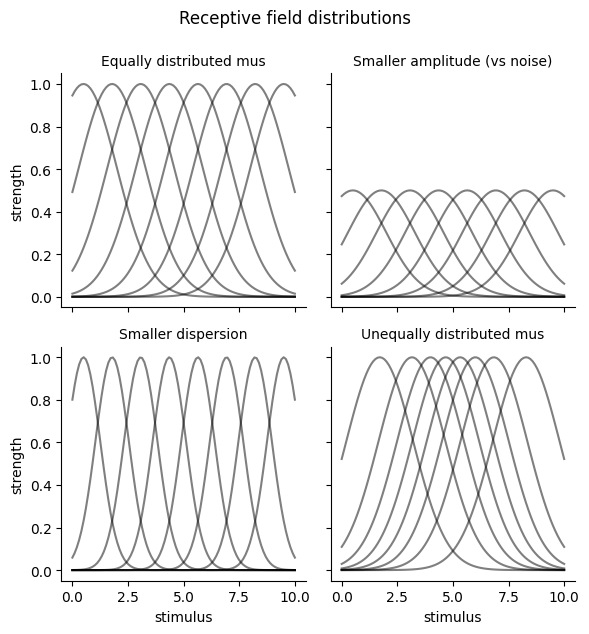

In [ ]:
tmp = preds.stack().to_frame('strength').join(fis)


g = sns.FacetGrid(col='set', col_wrap=2, data=tmp.reset_index(), sharey=True, palette=['k'])

g.map_dataframe(sns.lineplot, 'stimulus', 'strength', hue='parameter', palette=['k'], alpha=0.5)
# g.map(sns.lineplot, 'stimulus', 'fisher information', color='r')


# g.add_legend()

g.set_titles('{col_name}')
g.fig.suptitle('Receptive field distributions', y=1.05)

Text(0.5, 0.98, 'Fisher information')

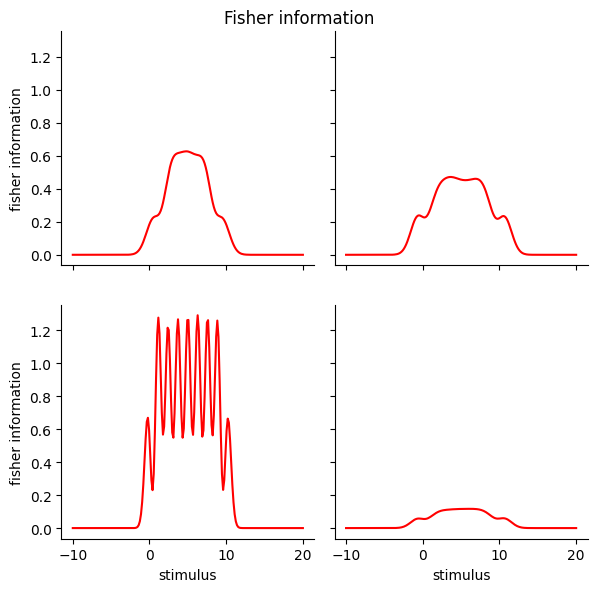

In [ ]:
# tmp = preds.stack().to_frame('strength').join(fis)



g = sns.FacetGrid(col='set', col_wrap=2, data=fis.reset_index(), sharey=True, palette=['k'])

g.map(sns.lineplot, 'stimulus', 'fisher information', color='r')


g.add_legend()

g.set_titles('')
g.fig.suptitle('Fisher information')